In [2]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import scipy.optimize as opt

In [3]:
STARTDATE = '01/01/2015'
ENDDATE = '12/31/2021'
INTERVAL = 'm' # monthly intervals

## Retrieving Data and Calculating Log Returns and Mean Returns

Value Stocks: AT&T, Intel, Meta, Google, Apple <br>
Growth Stocks: Adobe, Costco, Walmart, Tesla

In [4]:
valueStocks = ['T', 'INTC', 'META', 'GOOGL', 'AAPL', 'ADBE']
growthStocks = ["COST", "WMT", "TSLA"]

In [5]:
df = pdr.get_data_yahoo(valueStocks + growthStocks, start = STARTDATE, end = ENDDATE, interval = INTERVAL)['Adj Close']

In [6]:
returnsDF = np.log(df/df.shift(1)).dropna()*100 # converted to percent

In [7]:
assets = returnsDF.columns.values
meanReturnList = []
for asset in assets:
    print(f'The mean return for {asset} is {returnsDF[asset].mean():.3f}%')
    meanReturnList.append(returnsDF[asset].mean())

The mean return for T is 0.345%
The mean return for INTC is 0.691%
The mean return for META is 1.687%
The mean return for GOOGL is 1.924%
The mean return for AAPL is 2.245%
The mean return for ADBE is 2.417%
The mean return for COST is 1.702%
The mean return for WMT is 0.780%
The mean return for TSLA is 3.733%


## MAD Minimization

The Mean Absolute Deviation is defined as:
\begin{equation*}
\sum\limits_{t = 1}^T\left|\sum\limits_{i = 1}^n(r_{it} - \mu_i)x_i)\right|
\end{equation*}
Where there are $i = 1,\dots,n$-many assets over periods $t = 1,\dots,T$

In order to restructure this equation such that it can be formulated as a Linear Program, we use the following transformation:

\begin{gather*}
y_t - z_t = \sum\limits_{i=1}^n(r_{it} - \mu_{i})x_i\\
 y_t\geq 0, z_t\geq 0
\end{gather*}

This yields the following linear program model:
\begin{gather*}
\min_{y\geq 0, z\geq 0, x}\sum_{t=1}^T(y_t+z_t)\\
y_t-z_t = \sum_{i=1}^n(r_{it} - \mu_i)x_i, t = 1,\dots,T
\end{gather*}

In [8]:
minReturn = 1 # desired minimum return as a percentage as an additional constraint

We use the ``linprog`` class within ``scipy.optimize``. It should be noted that this class takes on optimization problems of the form:

\begin{gather*}
\min_x c^Tx \\
\text{s.t. } A_{ub}x \leq b_{ub}\\
A_{eq}x = b_{eq}\\
l \leq x \leq u
\end{gather*}

We must therefore convert the specified MAD minimization problem to take on a similar form. We begin by nothing that there are $T$-many values for each $y$ and $z$ and 4 $x$ values for each of the respective assets, resulting in the $\tilde{x}$ vector:

\begin{equation*}
\tilde{x} = \begin{bmatrix} y\\ x\\ z \end{bmatrix} \in \mathbb{R}^{(2T + 4)\times 1}
\end{equation*}

We restructure the MAD minimization problem as such:

\begin{gather*}
\min_{y\geq 0, z\geq 0,x\geq 0} \left\{\sum_{t=1}^T (y_t + z_t)\right\} \\
\text{s.t. } y_t - z_t - \sum_{i = 1}^n (r_{it}-\mu_i)x_i = 0 \text{ for } t = 1,\dots, T\\
\sum_{i}^n x_i = 1\\
-\sum_{i}^n\mu_ix_i \leq -\text{desired minimum return}
\end{gather*}

In [9]:
x0 = np.random.randn((2*len(returnsDF) + 9)) # specifying a dummy variable to hold x vector size

In [10]:
Aeq = np.zeros((len(returnsDF),len(x0)))

Noting that the middle 9 coefficients of the $A_{eq}$ matrix are attached to $x$, we can account for each $y_t - z_t$ as such:

In [11]:
for i in range(len(returnsDF)): Aeq[i,i] = 1 # holds the y variables
Aeq = Aeq - np.flip(Aeq,1) # flip negative holds the z variables

Next, we account for the $\sum_{i = 1}^n (r_{it}-\mu_i)x_i\text{ for }$ term for each $t$, parametrized by the rows of the $A_{eq}$ matrix. We also add a row of zeros to the entire matrix to hold the "weights" constraint.

In [12]:
for i in range(len(returnsDF)):
    for j in range(len(assets)):
        Aeq[i,len(returnsDF) + j] = -(returnsDF.iloc[i][assets[j]] - meanReturnList[j])
Aeq = np.append(Aeq,np.zeros((1,Aeq.shape[1])), axis = 0) # adding row of zeros to hold the =1 weights equality constraint

We can now construct the $A_{ub}$ matrix and finish constructing the $A_{eq}$ matrix by noting that the $x_i$'s are located at the middle four values of the $\tilde{x}$ vector:

In [13]:
Aub = np.zeros((1,len(x0)))

In [14]:
for i in range(len(meanReturnList)):
    # mean return constraint
    Aub[0,len(returnsDF) + i] = -meanReturnList[i]
    # adding the summation constraint, with strict equality
    Aeq[-1,len(returnsDF) + i] = 1

Now, noting that the objective function is simply the sum of all $y_t$ and $z_t$, can simply specify the $c$ vector to take on ones at these locations, with the middle four values corresponding to $x_i$ to be equal to zero.

In [15]:
c = np.zeros(Aeq.shape[1]); c[0:len(returnsDF)] = 1
c[len(returnsDF)+9:] = 1
c = np.reshape(c,(len(c),1))

Lastly, the $b_{eq}$ vector would take on zeros at all rows except for the last, corresponding with our specification of $A_{eq}$:

In [16]:
beq = np.zeros(Aeq.shape[0]); beq[-1] = 1 # summation equal to 1 constraint

In [17]:
res = opt.linprog(c,A_ub = Aub, b_ub = [minReturn], A_eq = Aeq, b_eq = beq)

In [18]:
print(f'The optimal value is {res.fun:.2f}')

The optimal value is 216.23


Verifying that the weights all sum to 1:

In [19]:
print(sum(res.x[len(returnsDF):len(returnsDF)+9]))

1.0000000001676068


Verifying that the minimum expected return constraint is also met:

In [20]:
sumCount = 0
for i in range(len(assets)):
    sumCount += meanReturnList[i]*res.x[len(returnsDF):len(returnsDF)+9][i]
print(sumCount)

1.0345832733893492


In [21]:
printing = [print(f'The optimal percent to invest in {assets[i]} is {res.x[len(returnsDF):len(returnsDF)+9][i]*100:.2f}%') for i in range(len(assets))]

The optimal percent to invest in T is 33.11%
The optimal percent to invest in INTC is 10.07%
The optimal percent to invest in META is 1.52%
The optimal percent to invest in GOOGL is 3.75%
The optimal percent to invest in AAPL is 0.00%
The optimal percent to invest in ADBE is 11.26%
The optimal percent to invest in COST is 11.62%
The optimal percent to invest in WMT is 26.66%
The optimal percent to invest in TSLA is 2.01%


## Benchmark Portfolios

In [22]:
# can uncomment the code below to retrieve all tickers of the S&P 500
# URL = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
# tickers = pd.read_html(URL)[0]['Symbol'].tolist()

We benchmark against the S&P500 index as well as the SPDR S&P 500 ETF Trust (SPY)

In [23]:
spIndexDF = pdr.get_data_yahoo('^GSPC', start = STARTDATE, end = ENDDATE, interval = INTERVAL)['Adj Close']
spyDF = pdr.get_data_yahoo('SPY', start = STARTDATE, end = ENDDATE, interval = INTERVAL)['Adj Close']

In [24]:
spIndexReturnsDF = pd.DataFrame(np.log(spIndexDF/spIndexDF.shift(1)).dropna()) # note that we do not convert to percentage here
spyReturnsDF = pd.DataFrame(np.log(spyDF/spyDF.shift(1)).dropna())

In [25]:
spIndexReturnsDF['CReturns'] = ((1+spIndexReturnsDF['Adj Close']).cumprod())
spyReturnsDF['CReturns'] = ((1+spyReturnsDF['Adj Close']).cumprod())

<AxesSubplot:xlabel='Date'>

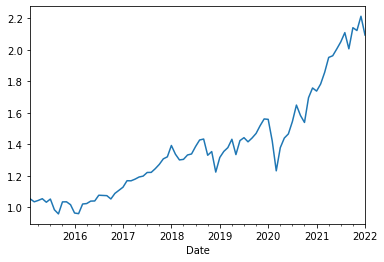

In [26]:
spIndexReturnsDF.CReturns.plot()

<AxesSubplot:xlabel='Date'>

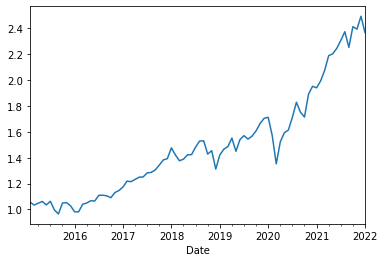

In [27]:
spyReturnsDF.CReturns.plot()

In [28]:
returnsDF = np.log(df/df.shift(1)).dropna()

In [29]:
weightsMADmin = res.x[len(returnsDF):len(returnsDF)+9]

In [30]:
returnsDFArray = returnsDF.to_numpy()

In [31]:
madPortfolioReturn = np.matmul(returnsDFArray, weightsMADmin)

In [32]:
madPortfolioReturnDF = pd.DataFrame(index = returnsDF.index, data = madPortfolioReturn, columns = ['return'])

In [33]:
madPortfolioReturnDF['CReturns'] = ((1+madPortfolioReturnDF['return']).cumprod())

<AxesSubplot:xlabel='Date'>

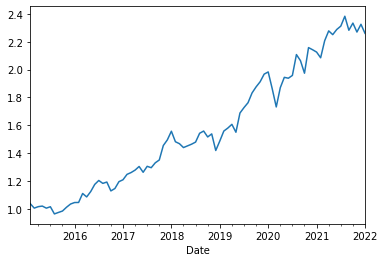

In [34]:
madPortfolioReturnDF.CReturns.plot()

### Overlaying Cumulative Returns Plot

In [35]:
import matplotlib.pyplot as plt

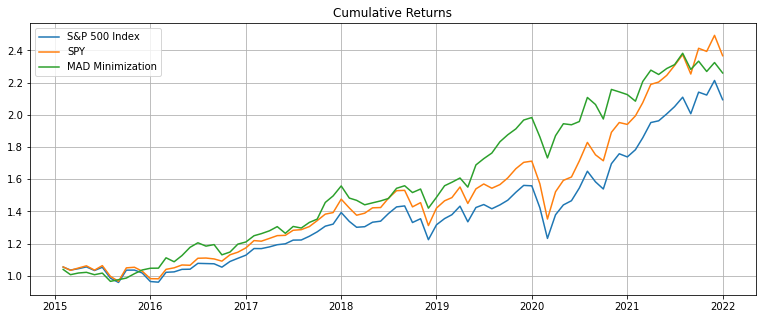

In [36]:
plt.figure(figsize=(13,5))
plt.plot(spIndexReturnsDF['CReturns'], label = 'S&P 500 Index')
plt.plot(spyReturnsDF['CReturns'], label = 'SPY')
plt.plot(madPortfolioReturnDF['CReturns'], label = 'MAD Minimization')
plt.legend()
plt.grid()
plt.title('Cumulative Returns')
plt.show()
plt.close()

### Calculating Relevant Porfolio Metrics

In [37]:
rf = 0.035 # we assume a risk free rate of 3.5% percent

In [45]:
volSP500 = np.std(spIndexReturnsDF['Adj Close'])*np.sqrt(12) # note that we annualize using sqrt(12) since we have monthly closing prices
volSPY = np.std(spyReturnsDF['Adj Close'])*np.sqrt(12)
volMAD = np.std(madPortfolioReturnDF['return'])*np.sqrt(12)

annReturnSP500 = np.mean(spIndexReturnsDF['Adj Close'])*12
annReturnSPY = np.mean(spyReturnsDF['Adj Close'])*12
annReturnMAD = np.mean(madPortfolioReturnDF['return'])*12

sharpeRatioSP500 = (annReturnSP500 - rf)/volSP500
sharpeRatioSPY = (annReturnSPY - rf)/volSPY
sharpeRatioMAD = (annReturnMAD - rf)/volMAD

In [47]:
print(f'The annualized volatility of the S&P500 Index is: {volSP500*100}%')
print(f'The annualized volatility of SPY is: {volSPY*100}%')
print(f'The annualized volatility of MAD Minimized Portfolio is: {volMAD*100}%')

print('*****')

print(f'The annualized expected return of the S&P500 Index is: {annReturnSP500*100}%')
print(f'The annualized expected return of SPY is: {annReturnSPY*100}%')
print(f'The annualized expected return of MAD Minimized Portfolio is: {annReturnMAD*100}%')

print('*****')

print(f'The Sharpe Ratio of the S&P500 Index is: {sharpeRatioSP500}')
print(f'The Sharpe Ratio of SPY is: {sharpeRatioSPY}')
print(f'The Sharpe Ratio of MAD Minimized Portfolio is: {sharpeRatioMAD}')

The annualized volatility of the S&P500 Index is: 14.518555377089843%
The annualized volatility of SPY is: 14.80852384630366%
The annualized volatility of MAD Minimized Portfolio is: 11.939088062734028%
*****
The annualized expected return of the S&P500 Index is: 11.66982742088735%
The annualized expected return of SPY is: 13.481868355319119%
The annualized expected return of MAD Minimized Portfolio is: 12.414999280672188%
*****
The Sharpe Ratio of the S&P500 Index is: 0.5627162764264596
The Sharpe Ratio of SPY is: 0.6740623480719641
The Sharpe Ratio of MAD Minimized Portfolio is: 0.7467068869773182


We see in the above results that annualized volatility for the MAD-minimized portfolio is the lowest, as expected. It, however, does not contain the highest Sharpe Ratio nor the highest expected returns.